In [1]:
import numpy as np
import pandas as pd

from nelson_siegel_svensson import NelsonSiegelSvenssonCurve
from nelson_siegel_svensson.calibrate import calibrate_nss_ols

import warnings
warnings.filterwarnings("ignore")


## Importation et préparation des données

####  Nous importons des données depuis Yahoo Finance sur des options call Apple pour des strikes et maturités différentes



In [2]:
import pandas as pd

def load_clean_option_data(path):
 
    df = pd.read_csv(path, sep=";", dtype=str)

    df = df.dropna(axis=1, how='all')
    df = df.dropna(how='all')

    df.replace("-", pd.NA, inplace=True)

    df["date_obs"] = pd.to_datetime(df["date_obs"], errors="coerce", dayfirst=True)
    df["date_expiration"] = pd.to_datetime(df["date_expiration"], errors="coerce", dayfirst=True)

    colonnes_a_convertir = [col for col in df.columns if col not in ["date_obs", "date_expiration"]]
    
    for col in colonnes_a_convertir:
        df[col] = (
            df[col]
            .str.replace(",", "", regex=False)  
            .str.replace(" ", ""))
        df[col] = pd.to_numeric(df[col], errors="coerce") 

    df.dropna(subset=["strike", "bid", "ask"], inplace=True)

    df["price"] = (df["bid"] + df["ask"]) / 2

    df["maturity"] = (df["date_expiration"] - df["date_obs"]).dt.days / 365.25

    df = df[(df["strike"] >= 99)]
    df = df[df["date_obs"] == "2025-03-23"]
    df = df[df["maturity"] > 0.02]

    return df

file_path = "data_aapl.csv"

df = load_clean_option_data(file_path)

#### Récupération du rendement moyen d'Apple sur les deux dernière années depuis Alpha Vantage

In [3]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# Clé API Alpha Vantage
api_key = "MIIVXF8JB039243Q"
symbol = "AAPL"

url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize=full&apikey={api_key}"

response = requests.get(url)
data = response.json()

if 'Time Series (Daily)' not in data:
    print("Erreur dans la réponse API :", data)
else:
    df_aapl = pd.DataFrame.from_dict(data['Time Series (Daily)'], orient='index', dtype=float)
    df_aapl.index = pd.to_datetime(df_aapl.index)
    df_aapl.sort_index(inplace=True)

    deux_ans = datetime.today() - timedelta(days=730)
    df_aapl = df_aapl[df_aapl.index >= deux_ans]

    df_aapl['close'] = df_aapl['4. close']
    df_aapl['daily_return'] = df_aapl['close'].pct_change()

    rendement_moyen = df_aapl['daily_return'].mean() * 100

    rendement_moyen_quotidien = df_aapl['daily_return'].mean()
    mu = (1 + rendement_moyen_quotidien)**252 - 1  # Rendement annuel

    print(f"Rendement annuel : {mu:.4f}")


Rendement annuel : 0.1099


#### Calibration de la courbe de taux zéro-coupon à l’aide du modèle NSS, puis calcul des taux et des facteurs d’actualisation pour chaque maturité du DataFrame

In [4]:
yield_maturities = np.array([1/12, 2/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
yeilds = np.array([4.38, 4.33, 4.34, 4.29, 4.05, 3.99, 4.01, 4.09, 4.21, 4.32, 4.66, 4.62]).astype(float)/100


#NSS model calibrate
curve_fit, status = calibrate_nss_ols(yield_maturities,yeilds)

df['rate'] = df['maturity'].apply(curve_fit)
df["actualisation"] = np.exp(-df["rate"] * df["maturity"])

#### Création d'un dataset d'entrainement et un de test pour notre modèle

In [5]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42) 


## Simulation des chemin de sous-jacent avec Heston 

### Calibration du modèle de Heston

In [6]:
from heston_calibration import Heston

resultat = Heston.calibration(df_train)


=== Résultats de la calibration ===
Paramètre  | Valeur calibrée
------------------------------
v0         | 0.0836         
kappa      | 3.0263         
theta      | 0.0525         
sigma      | 0.1466         
rho        | -0.7289        
lambd      | 0.0874         

--- Statistiques d'erreur ---
Erreur quadratique minimale : 3.2637
Nombre de points de calibration : 134
MSE : 0.024356
RMSE : 0.156065
Moyenne des prix du marché : 32.0845


### Simulation des trajectoires de sous-jacents à l'aide du modèle de Heston calibré

In [7]:
import numpy as np
import matplotlib.pyplot as plt


def simulate_heston_paths(S0, n, steps, T=1, kappa=2.0, theta=0.02, eta=0.1, mu=0.0):
    dt = T / steps
    dW_s = np.random.normal(0, np.sqrt(dt), (n, steps))
    dW_v = np.random.normal(0, np.sqrt(dt), (n, steps))

    S = np.zeros((n, steps))
    volatility = np.zeros((n, steps))
    S[:, 0] = S0
    volatility[:, 0] = theta

    for t in range(1, steps):
        volatility[:, t] = (
            volatility[:, t - 1]
            + kappa * (theta - volatility[:, t - 1]) * dt
            + eta * np.sqrt(np.maximum(volatility[:, t - 1], 0)) * dW_v[:, t]
        )
        volatility[:, t] = np.maximum(volatility[:, t], 0)

        dS = mu * S[:, t - 1] * dt + np.sqrt(volatility[:, t - 1]) * S[:, t - 1] * dW_s[:, t]
        S[:, t] = S[:, t - 1] + dS

    return S

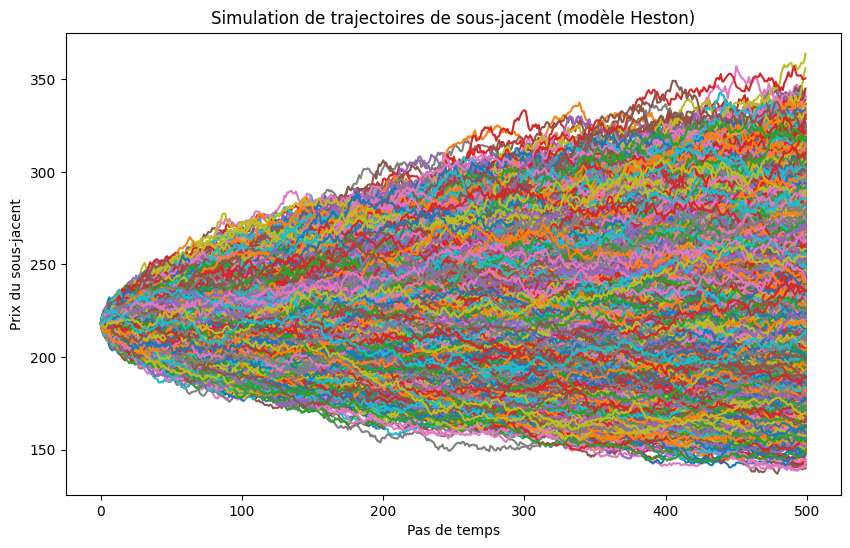

In [8]:
v0, kappa, theta, sigma, rho, lambd = resultat.x
T = df["maturity"].max()
eta = sigma

S0 = 218.27  # Prix initial au moment de la récupération des données
num_paths = 100000  # nb trajectoires
steps = 500  # nb étapes


S = simulate_heston_paths(S0, num_paths, steps, T,  kappa, theta, eta, mu)

# Affichage des trajectoires simulées
plt.figure(figsize=(10, 6))
for i in range(num_paths):
    plt.plot(S[i, :], label=f"Trajectoire {i+1}")
plt.title('Simulation de trajectoires de sous-jacent (modèle Heston)')
plt.xlabel('Pas de temps')
plt.ylabel('Prix du sous-jacent')
plt.show()


### Définition du dictionnaire qui contiendra les pondérations pour chaque maturité

In [9]:
unique_maturities = sorted(df["maturity"].unique())

max_maturity = max(unique_maturities)

maturity_reference = {}

for maturity in unique_maturities:
    maturity_key = float(maturity)
    normalized_step = int((maturity_key / max_maturity) * steps)
    maturity_reference[maturity_key] = {
        "step": normalized_step,
        "proba": None
    }

## Calcul des payoff actualisés des simulations

In [10]:
import numpy as np

def calcul_cashflows_unique(strike, maturity, rate, S, maturity_reference):
    
    # Récupérer les prix simulés à la dernière étape (date d'expiration)

    step = maturity_reference[maturity]["step"]

    S_final = S[:, step-1]  # Dernier prix simulé pour chaque chemin
    
    # Calculer le cashflow pour chaque chemin simulé (option call)
    cashflows = np.maximum(S_final - strike, 0)
    
    # Actualiser les cashflows en fonction de la maturité (en années)
    actualisation = np.exp(-rate * maturity)  # Actualisation basée sur la maturité
    cashflows *= actualisation
    
    return cashflows

def calcul_cashflows_from_df(df, S, maturity_reference):

    num_paths = len(S)

    # Extraire les strikes et maturités depuis df
    strikes = df['strike'].values
    maturities = df['maturity'].values  
    rates = df['rate'].values

    
    
    num_benchmarks = len(strikes)  # Nombre d'options (benchmarks)
    
    # Initialisation du tableau de cashflows actualisés
    cashflows = np.zeros((num_paths, num_benchmarks))
    
    # Calcul des cashflows actualisés pour chaque option en utilisant calcul_cashflows_unique
    for j in range(num_benchmarks):
        strike = strikes[j]
        maturity = maturities[j]
        rate = rates[j]
        
        # Appeler la fonction pour calculer les cashflows pour chaque option (benchmark)
        cashflows[:, j] = calcul_cashflows_unique(strike, maturity, rate, S, maturity_reference)
    
    return cashflows


cashflows = calcul_cashflows_from_df(df_train, S, maturity_reference)



## Calibration de Monte Carlo

### Fonctions de calibration

In [11]:
import numpy as np
from scipy.optimize import minimize

def compute_probabilities(cashflows, lambda_):
    exponents = np.dot(cashflows, lambda_)
    max_exp = np.max(exponents)
    shifted_exps = np.exp(exponents - max_exp)
    return shifted_exps / np.sum(shifted_exps)

def objective_function(lambda_, cashflows, market_prices, reg=1e-5):
    p = compute_probabilities(cashflows, lambda_)
    model_prices = np.dot(p, cashflows)  # (n_benchmarks,)
    error = np.sum((model_prices - market_prices)**2)
    return error + reg * np.sum(lambda_**2)

def gradient(lambda_, cashflows, market_prices, reg=1e-5):
    p = compute_probabilities(cashflows, lambda_)
    g = cashflows                       
    model_prices = np.dot(p, g)  

    weighted = (model_prices - market_prices)[np.newaxis, :] * g  

    grad = 2 * np.dot(p, weighted) 
    grad += 2 * reg * lambda_
    return grad



def calibrate_weights(cashflows, market_prices, maxiter=500):

    cashflows = np.asarray(cashflows)
    market_prices = np.asarray(market_prices).flatten()

    assert cashflows.shape[1] == len(market_prices), (
        f"Dimensions incohérentes: {cashflows.shape[1]} benchmarks vs {len(market_prices)} prix"
    )
    
    lambda_init = np.zeros(cashflows.shape[1]) + 1e-5
    
    res = minimize(
        fun=objective_function,
        x0=lambda_init,
        args=(cashflows, market_prices),
        jac=gradient,
        method='L-BFGS-B',
        options={'maxiter': maxiter, 'ftol': 1e-8}
    )
    
    lambda_opt = res.x
    probs = compute_probabilities(cashflows, lambda_opt)
    
    return lambda_opt, probs, res


### Calibrations et Calculs des jeux de poids attribués à chaque chemin (un jeux pas maturité)

In [12]:
for mat in df_train['maturity'].unique():
    df_mat = df_train[df_train['maturity'] == mat]
    C_mat = df_mat['price'].values

    indices = np.where(df_train['maturity'].values == mat)[0]

    cashflow_mat = cashflows[:, indices]

    lambda_opt_mat, probs_mat, result_mat = calibrate_weights(cashflow_mat, C_mat)

   
    maturity_reference[mat]["proba"] = probs_mat

    

### Analyse de la performance des simulations du modèle

In [13]:
results = []

for mat in df_test['maturity'].unique():
    df_mat = df_test[df_test['maturity'] == mat]

    res_test = pd.DataFrame(np.zeros((len(df_mat), 2)), columns=['price_market', 'price_simulated'])
    
    for i in range(len(df_mat)):
        mat_i = df_mat["maturity"].iloc[i] 
        strike_test = df_mat["strike"].iloc[i]
        price_test = df_mat["price"].iloc[i]
        rate_test = df_mat["rate"].iloc[i]
        probs = maturity_reference[mat_i]["proba"]

        mat_cashflow = calcul_cashflows_unique(strike_test, mat_i,rate_test, S, maturity_reference)
        price_simulated = np.dot(probs, mat_cashflow)

        res_test.at[i, "price_market"] = price_test
        res_test.at[i, "price_simulated"] = price_simulated

    # Calcul du RMSE pour cette maturité
    rmse = np.sqrt(np.mean((res_test["price_market"] - res_test["price_simulated"]) ** 2))
    
    # Création du tableau final
    results.append({"maturity": f"{int(mat * 365.25)} j", "RMSE": rmse})


# Création du tableau final
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="maturity").reset_index(drop=True)
print(df_results)


  maturity      RMSE
0     12 j  0.469560
1     33 j  0.434747
2     54 j  1.154429
3     89 j  0.780504


## Nape de volatilité

In [14]:
from scipy.stats import norm
from scipy.interpolate import interp1d
import plotly.graph_objects as go


# Fonction pour calculer la volatilité implicite via Newton-Raphson
def calculate_implied_vol_weighted(option_price, S, K, T, r, option_type='call', max_iter=100):
    sigma = 0.5   
    tolerance = 1e-5

    for _ in range(max_iter):
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        if option_type == 'call':
            price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        else:
            price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

        vega = S * norm.pdf(d1) * np.sqrt(T)

        diff = option_price - price
        if abs(diff) < tolerance:
            return sigma

        sigma += diff / vega

    return sigma  




In [15]:
spot_price = 218.27
risk_free_rate = df['rate'].mean() # Taux d'intérêt moyen
strikes = np.linspace(0.80 * spot_price, 1.25 * spot_price, 30)
maturities_known = df['maturity'].unique()       
maturities_known = np.sort(maturities_known)      

implied_vols = np.zeros((len(strikes), len(maturities_known)))

# On débute avec les maturités connues, dont nous connaissons les pondérations
for i, mat_i in enumerate(maturities_known):

    probs = maturity_reference[mat_i]["proba"]
    
    for j, K in enumerate(strikes):
        
        # Prix simulé en combinant 'probs' et le payoff
        mat_cashflow = calcul_cashflows_unique(K, mat_i, risk_free_rate, S, maturity_reference)
        price_simulated = np.dot(probs, mat_cashflow)
        
        iv = calculate_implied_vol_weighted(
            option_price=price_simulated,
            S=spot_price,
            K=K,
            T=mat_i,
            r=risk_free_rate,
            option_type='call')
        
        implied_vols[j, i] = iv


# On crée une grille de maturités plus fine pour l'interpolation
maturities_fine = np.linspace(maturities_known.min(), maturities_known.max(), 15)

implied_vols_interp = np.zeros((len(strikes), len(maturities_fine)))

# Pour chaque strike, on interpole sur la dimension "maturity"
for idx_strike in range(len(strikes)):
    iv_curve = implied_vols[idx_strike, :] 
    
    # Fonction d'interpolation linéaire
    f = interp1d(
        maturities_known,
        iv_curve,
        kind='linear', 
        fill_value='extrapolate'
    )
    
    implied_vols_interp[idx_strike, :] = f(maturities_fine)



In [16]:

# Meshgrid pour les axes
M_grid, K_grid = np.meshgrid(maturities_fine, strikes)

colorscale_focus = [
    [0.00, 'rgb(0, 0, 100)'],   
    [0.05, 'rgb(0, 0, 255)'],  
    [0.10, 'rgb(0, 128, 255)'], 
    [0.15, 'rgb(0, 255, 255)'],
    [0.20, 'rgb(0, 255, 128)'], 
    [0.25, 'rgb(0, 255, 0)'],   
    [0.40, 'rgb(128, 255, 0)'], 
    [0.55, 'rgb(255, 255, 0)'], 
    [0.70, 'rgb(255, 128, 0)'], 
    [1.00, 'rgb(255, 0, 0)']   
]


iv_min, iv_max = 0.2, 0.6
normalized_vols = (implied_vols_interp - iv_min) / (iv_max - iv_min)
normalized_vols = np.clip(normalized_vols, 0, 1)


fig = go.Figure(data=[go.Surface(
    x=M_grid,
    y=K_grid,
    z=implied_vols_interp,       
    surfacecolor=normalized_vols,
    colorscale=colorscale_focus,
    showscale=True,
    colorbar=dict(title='Implied Volatility')
)])


# Mise en forme
fig.update_layout(
    title='Skew AAPL Implied Volatility Surface',
    scene=dict(
        xaxis_title='Maturity (Years)',
        yaxis_title='Strike',
        zaxis_title='Implied Volatility',
    ),
    autosize=True,
    margin=dict(l=0, r=0, b=0, t=50),
    template='plotly_dark'
)

